In [2]:
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk

import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold


from playsound import playsound

In [3]:
import random
random.seed(100)
random_state = 100

In [4]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from gensim.models.phrases import Phrases, Phraser

In [5]:
path_df = "..\\data\\original\\2019\\"
path_data_processed = "..\\data\\processed\\2019\\"

In [6]:
bigram_reloaded = Phraser.load(path_data_processed+"bigrams2019.pkl")

## Embeddings

La idea principal de Word-embeddings es a partir de un corpus de texto y a partir de la estadística de distribución de las palabras que aparecen en el corpus, poder describir vectorialmente cada palabra de mi vocabulario de tal modo que las palabras de similar significado queden cerca.

### Método: Word 2vec.

Word2-vec Skipgram: A partir de una palabra central te devuelve las probabilidades de las palabras del **contexto** 

Si dice "Mal seguro la_caja" quiero predecir las palabras del contexot, es decir, la probabilidad de que aparezca mal y la caja dado la palabra objetivo seguro.

One-hot encoder, es cómo ingresa en la red las palabras, se puede pensar cómo una matriz termino contexto. También al encodear las palabras en función de su contexto estoy reduciendo dimensionalidad.

**usa soft-max**, en donde tengo en el numerador la palabra objetivo con un contexto (representación particular) dividido la sumatoria de todos los productos posibles. Estoy viendo que tanto más grande es que aparezca seguro en contexto de mal y la caja, versus a todas las otras opciones (podrian ser más palabras, depende de la ventana que le fije)

Achicar las dimensiones para que palabras similares se presenten de manera parecida. 


**Evaluación de los textos:**

1. ¿Puedo resolver el Toefl Test con WE?
2. Tageos humanos vs embeedings (correlation)
3. Sillohoute test: Técnica de evaluación de los métodos. Para evaluar tus embeddings. 
4. Evaluación extrínseca, probar el embedding en la tarea de NLP y evaluar esa tarea concreta






### Word2Vec en la Librería Gensim

* "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
* "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
* "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
* "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
* "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
* "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
* para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html


In [7]:

w2v_model = Word2Vec(bigram_reloaded, workers=4,size=20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)
#w2v_model.save("word2vec_20dim")  # save model
#w2v_model = Word2Vec.load("word2vec_20dim")  # load model

In [8]:
# the output of a word2vec representation is a numpy array 
w2v_model.wv["bueno"]

array([ 0.08198045, -0.24783456, -0.02494639,  0.20246114, -0.1109058 ,
       -0.4954993 ,  0.7876787 , -1.1467303 , -0.2766222 ,  0.06910264,
        0.6318629 ,  0.46824315, -0.39935896,  0.41357544, -0.38685492,
        0.60702556,  0.0168582 , -0.01864571,  0.60022706,  0.39964178],
      dtype=float32)

In [9]:
w2v_model.wv.n_similarity(["atencion"], ["bueno"])

0.50016797

In [10]:
w2v_model.wv.n_similarity(["atencion"], ["malo"])

0.36402518

In [11]:
w2v_model.wv.n_similarity(["auxilio"], ["bueno"])

0.5281231

In [12]:
w2v_model.wv.n_similarity(["auxicaja"], ["malo"])

0.73154986

In [13]:
w2v_model.wv.n_similarity(["auxicaja"], ["bueno"])

0.692137

In [16]:
w2v_model.most_similar(positive=["chofer"],negative=["bueno"], topn=25)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('llegar', 0.4753281772136688),
 ('destino', 0.4689069986343384),
 ('minutos', 0.4648170471191406),
 ('min', 0.46044230461120605),
 ('lugar', 0.4576099216938019),
 ('media_hora', 0.45317336916923523),
 ('bateria', 0.4474932849407196),
 ('venir', 0.44473710656166077),
 ('zona', 0.4437284469604492),
 ('encontraba', 0.4412122368812561),
 ('horas', 0.4409620761871338),
 ('espere', 0.44094863533973694),
 ('noche', 0.4404401481151581),
 ('movil', 0.43980106711387634),
 ('horario', 0.4350438714027405),
 ('vino', 0.43384885787963867),
 ('chico', 0.4327681362628937),
 ('hora_media', 0.42696258425712585),
 ('tardo', 0.42185676097869873),
 ('hs', 0.4210510551929474),
 ('mecanico', 0.41636985540390015),
 ('centro', 0.4136355221271515),
 ('senor', 0.40972602367401123),
 ('sr', 0.4069020450115204),
 ('camion', 0.4061741232872009)]

In [32]:
w2v_model.most_similar(positive=["auxilio"], topn=25)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mecanico', 0.9322543144226074),
 ('remolque', 0.8847731351852417),
 ('dentro', 0.8749565482139587),
 ('minutos', 0.8634153604507446),
 ('asistencia', 0.8603384494781494),
 ('previsto', 0.8478215932846069),
 ('auxilios', 0.8415802717208862),
 ('puntual', 0.8402666449546814),
 ('esperado', 0.8317940831184387),
 ('estipulado', 0.8311910033226013),
 ('tiempo_estimado', 0.8298046588897705),
 ('indicado', 0.826800525188446),
 ('plazo', 0.8260867595672607),
 ('normal', 0.8218731880187988),
 ('hora', 0.8200687766075134),
 ('choferes', 0.8195258378982544),
 ('horario', 0.8174401521682739),
 ('auxicaja', 0.8169718384742737),
 ('chofer', 0.8129899501800537),
 ('asistencia_mecanica', 0.8129028081893921),
 ('ayuda', 0.8127695918083191),
 ('pactado', 0.8117178082466125),
 ('acarreo', 0.8115530014038086),
 ('acudir', 0.8084463477134705),
 ('media_hora', 0.8080952167510986)]

In [33]:
w2v_model.most_similar(positive=["atencion"], topn=25)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('atencionon', 0.816602349281311),
 ('precisa', 0.802586555480957),
 ('bueno_atencion', 0.7919986844062805),
 ('trato', 0.7916243672370911),
 ('expeditiva', 0.7905966639518738),
 ('concreta', 0.790440559387207),
 ('agente', 0.7882944941520691),
 ('manera', 0.7855509519577026),
 ('paciencia', 0.7852509021759033),
 ('pedidos', 0.784740149974823),
 ('destacar', 0.7845419645309448),
 ('gentil', 0.7841759920120239),
 ('presencia', 0.7836843729019165),
 ('mucha', 0.7831488251686096),
 ('informacion', 0.7820988297462463),
 ('diligencia', 0.7817652821540833),
 ('altamente', 0.781431257724762),
 ('cumplimiento_pactado', 0.7813123464584351),
 ('correccion', 0.7811586856842041),
 ('cordiales', 0.7810245156288147),
 ('correctos', 0.7802594900131226),
 ('preguntas', 0.7784456610679626),
 ('dispuesto', 0.7779945135116577),
 ('disposicion', 0.7770158648490906),
 ('calidez', 0.7766037583351135)]

**Analogias** Cómo podemos escribir a una palabra cómo un vector de significados según la distancia a otras palabras, podemos entenoces hacer analogias, al punto de determina que si rey-reina y hombre-mujer, podemos determinar que rey-hombre = reina y así pensar analogías.

In [34]:
w2v_model.most_similar(positive=["bueno"], negative=["malo"], topn=10)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bueno_atencion', 0.5030709505081177),
 ('calidad', 0.48703616857528687),
 ('eficiencia', 0.4862215518951416),
 ('seriedad', 0.44340747594833374),
 ('cordial', 0.42249366641044617),
 ('efectividad', 0.42239052057266235),
 ('cordialidad', 0.4219539165496826),
 ('confiabilidad', 0.42132192850112915),
 ('prestacion', 0.4125654101371765),
 ('inquietudes', 0.4096635580062866)]

In [35]:
w2v_model.most_similar(positive=["malo"], negative=["bueno"], topn=10)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mandar', 0.6710126996040344),
 ('llanta', 0.657471776008606),
 ('factura', 0.6401127576828003),
 ('pidieron', 0.63575279712677),
 ('diciembre', 0.6301542520523071),
 ('dije', 0.624458909034729),
 ('verguenza', 0.6195811033248901),
 ('vencido', 0.617263913154602),
 ('cobrar', 0.6156707406044006),
 ('podian', 0.6143389344215393)]

<AxesSubplot:>

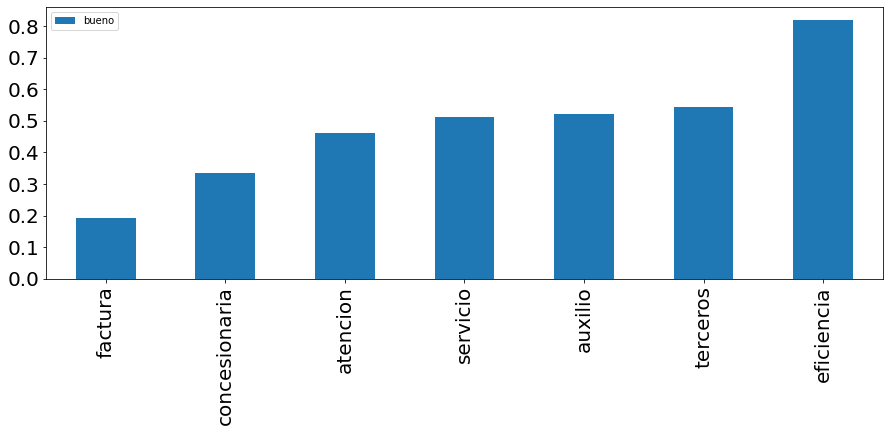

In [14]:
target_word="bueno"
actores = ["auxilio","servicio","atencion","eficiencia","terceros","concesionaria","factura"]
fun_score = []
for actor in actores:
    fun_score.append(w2v_model.wv.n_similarity([target_word], [actor]))
    
pd.DataFrame(fun_score,index = actores,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20)

<AxesSubplot:>

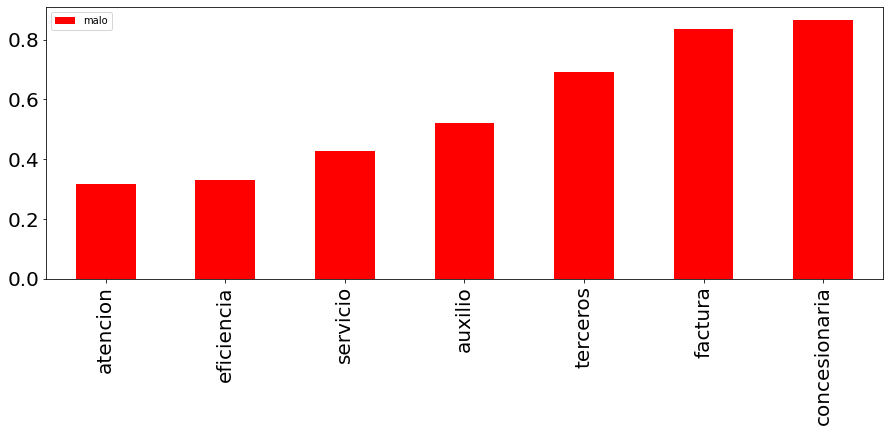

In [15]:
target_word="malo"
actores = ["auxilio","servicio","atencion","eficiencia","terceros","concesionaria","factura"]
fun_score = []
for actor in actores:
    fun_score.append(w2v_model.wv.n_similarity([target_word], [actor]))
    
pd.DataFrame(fun_score,index = actores,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20, color= "red")

In [16]:
sectores = ["auxilio","atencion","call_center","factura"]
positividad = ["eficiencia","efectividad","cumplimiento","agilidad","cordial","satisfactoria","confiabilidad","velocidad","calidad","bueno_atencion","rapidez","expeditivos"]
negatividad = ["negaron","esposa","malo","dare_baja","quedarme","cobrar","costo"]
palabras = sectores + positividad + negatividad
colores = ["black"]*len(sectores)+["green"]*len(positividad)+["red"]*len(negatividad) 

In [17]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))
print (distancias.shape)
distancias

(23, 23)


array([[5.96046448e-08, 4.95235801e-01, 3.30175638e-01, 6.92444921e-01,
        4.82150614e-01, 5.33080101e-01, 3.63868535e-01, 8.81573945e-01,
        3.86709988e-01, 5.41800380e-01, 5.78653097e-01, 4.88729656e-01,
        5.14301509e-01, 5.38655221e-01, 5.67506760e-01, 5.19967586e-01,
        5.10827184e-01, 4.55611825e-01, 4.79882061e-01, 5.00822961e-01,
        4.26531613e-01, 6.05935514e-01, 5.88167906e-01],
       [4.95235801e-01, 0.00000000e+00, 3.63655388e-01, 7.72833213e-01,
        3.11050951e-01, 2.82169938e-01, 4.00519133e-01, 4.73532379e-01,
        2.60815084e-01, 2.84793437e-01, 3.12576652e-01, 3.43766034e-01,
        3.29846859e-01, 2.08001256e-01, 5.95423102e-01, 2.70462275e-01,
        6.77624732e-01, 6.61126316e-01, 6.81981564e-01, 5.66584200e-01,
        6.53525233e-01, 8.82330738e-01, 7.90095940e-01],
       [3.30175638e-01, 3.63655388e-01, 0.00000000e+00, 4.05645847e-01,
        4.12424326e-01, 3.66592228e-01, 4.29847300e-01, 5.52952468e-01,
        2.67886102e-01

In [18]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

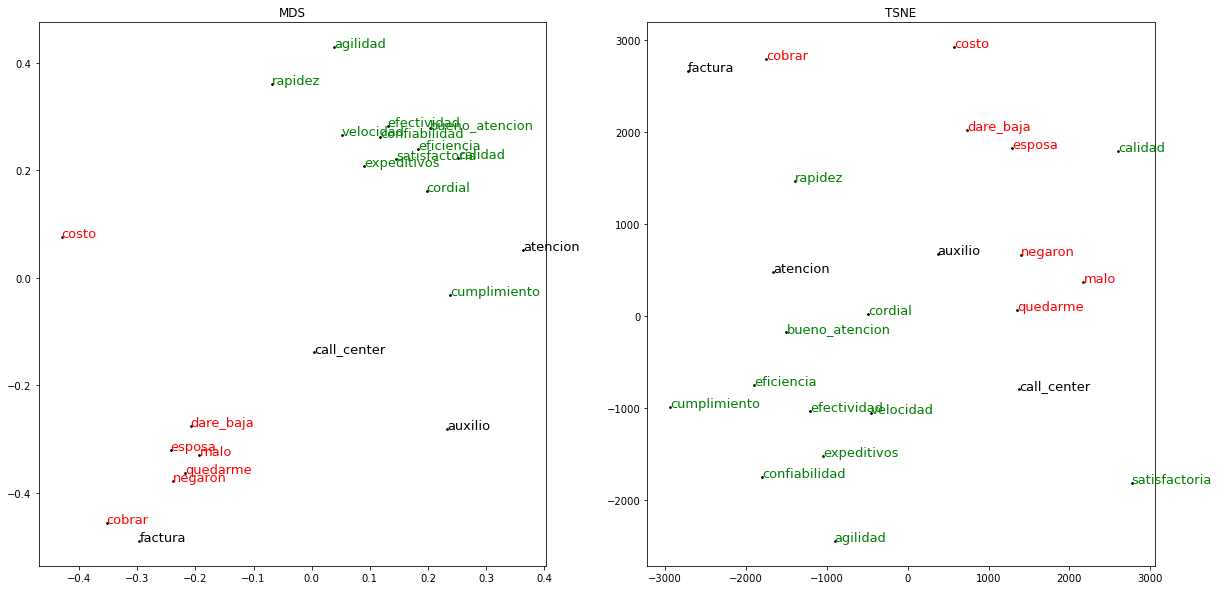

In [19]:
visualize_embeddings(distancias,palabras,colores,perplexity=4)

## Analogías

Si factura se asocia a cobrar y dare de baja, atencion es analogo a que?

In [29]:
# pretty print function
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = w2v_model.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

servicios = ['auxilio', 'factura', 'atencion', 'servicio', 'call_center']
atributos = [analogy('malo', 'bueno', servicio) for servicio in servicios]


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [30]:
pp(zip(atributos,servicios))

0            1
0        prestado      auxilio
1        efectivo      factura
2  bueno_atencion     atencion
3      prestacion     servicio
4         cordial  call_center


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


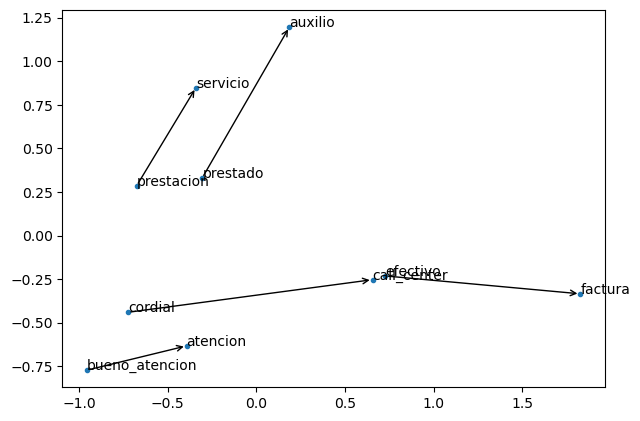

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_data(orig_data, labels):
    pca = PCA(n_components=2)
    data = pca.fit_transform(orig_data)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(data[:,0], data[:,1], '.')
    for i in range(len(data)):
        plt.annotate(labels[i], xy = data[i])
    for i in range(len(data)//2):
        plt.annotate("",
                xy=data[i],
                xytext=data[i+len(data)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3")
        )
       
labels = servicios + atributos
data = [w2v_model[w] for w in labels]
plot_data(data, labels)

El mapa determina la distancia entre servicios y muestra cuál servicio está más cerca del otro en un espacio de dos dimensiones. Luego la flecha indica la relación entre servicios y atributos.

In [21]:
playsound('war.mp3')